In [1]:
# 导入需要的模块

import sklearn
import numpy as np
# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### 本章将使用MNIST数据集，这是一组由美国高中生和人口调查局员工手写的70 000个 数字的图片。
### 每张图片都用其代表的数字标记。这个数据集被广为使用，因此也被称作是机器学习领域的“Hello World”：
### 但凡有人想到了一个新的分类算法，都会想看看在 MNIST上的执行结果。
### 因此只要是学习机器学习的人，早晚都要面对MNIST。

### sklearn.datasets
### 根据所需的数据集类型，可以使用三个主要的数据集接口来获取数据集。
### The dataset loaders（数据集加载器）。它们可用于加载小的标准数据集，如“ 玩具数据集”部分所述。
### The dataset fetchers（数据集提取程序）。它们可用于下载和加载更大的数据集，如“ 现实世界数据集”部分所述。
### The dataset generation functions（数据集生成函数）。它们可用于生成受控的合成数据集，如“ 生成的数据集”部分所述

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

C:\Users\15517\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:65: RuntimeWarning: Invalid cache, redownloading file
  warn("Invalid cache, redownloading file", RuntimeWarning)


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
type(mnist)

sklearn.utils.Bunch

Bunch本质上的数据类型是dict，属性有：

DESCR：数据描述。

target_names：标签名。可自定义，默认为文件夹名。

filenames：文件名。 

target：文件分类。如猫狗两类的话，与filenames一一对应为0或1。 

data：数据数组。

[参考链接](https://blog.csdn.net/ndhuaerfeifei/article/details/104145367)

In [5]:
X,y = mnist['data'],mnist['target']

In [6]:
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

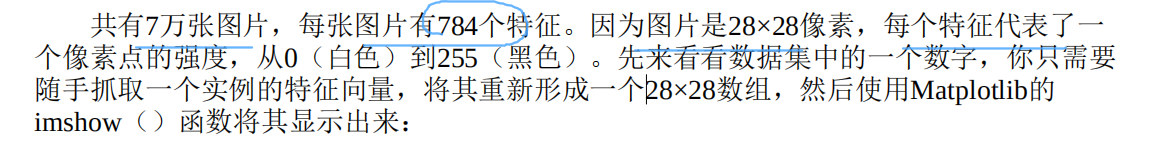

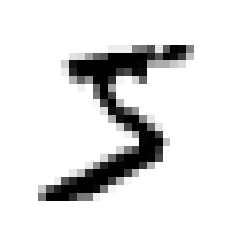

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image,cmap='binary')
plt.axis('off')
plt.show();

In [12]:
y[0]  #查看上述模糊数字的真实值

'5'

In [18]:
# 注意到上述输出为字符型
type(y[0])

# 将y转为数字型
y = y.astype(np.uint8)
type(y[0])

numpy.uint8

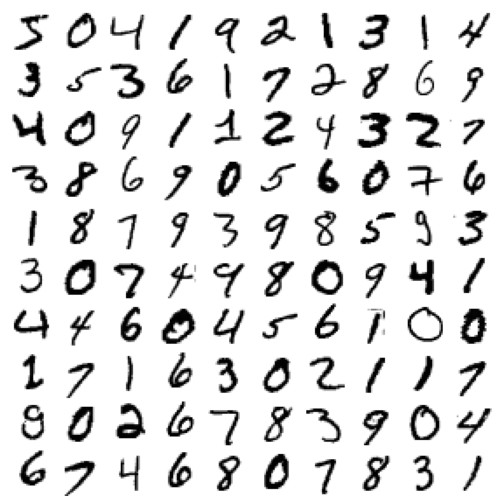

In [21]:
# 查看多一些的数字图片
def plot_digit(data):
    image = data.reshape(28, 28)  # 将图片大小设置为28*28
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")  # plt.imshow 图像的形式显示数据，即在一个2D常规光栅上显示数据。
    plt.axis("off") #关闭轴和标签

# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
    
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

### 研究之前，先将数据集进行分组：测试集和训练集；MNIST已经分好，前60000张为训练集，后10000张为测试集

In [19]:
X_train,Xtest,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

## 训练二元分类器

In [31]:
# 先简化一个分类5的分类器，是5的为True，不是的为False
y_train_5 = (y_train == 5)
print(y_train_5.sum())
y_test_5 = (y_test == 5)
y_test_5.sum()

5421


892

# 初始选择随机梯度下降(SGD)分类器，使用Skilearn的SGDClassifier
[参考链接](https://blog.csdn.net/WxyangID/article/details/80365779?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522165328800816782184638002%2522%252C%2522scm%2522%253A%252220140713.130102334..%2522%257D&request_id=165328800816782184638002&biz_id=0&utm_medium=distribute.pc_search_result.none-task-blog-2~all~sobaiduend~default-2-80365779-null-null.142^v10^pc_search_result_control_group,157^v5^control&utm_term=sgdclassifier&spm=1018.2226.3001.4187)
[官方社区](http://scikit-learn.org.cn/view/388.html)

In [34]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [35]:
sgd_clf.predict([some_digit])

array([ True])

## 3.3 性能测量

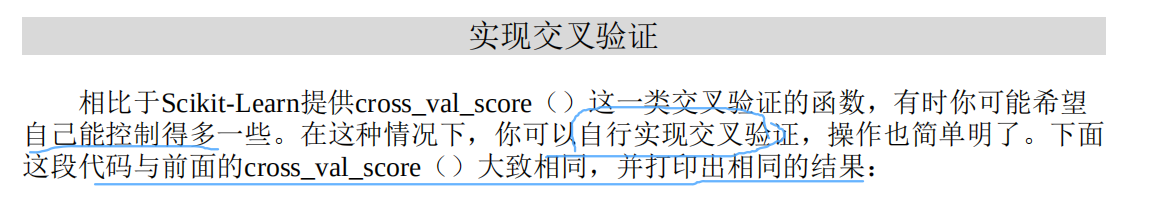

In [40]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3,shuffle=True,random_state=42)

for train_index, test_index in skfolds.split(X_train,y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) 

0.9669
0.91625
0.96785


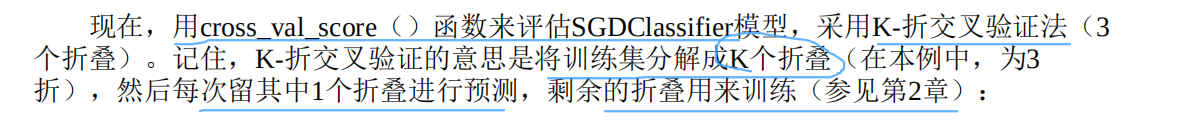

In [41]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5, cv = 3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

### 大眼一看，发现准确率都在95%以上，突然觉得好牛逼， 但是.....
### 先来看一个非常蠢得分类器，将每张图片都看成5

In [46]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [48]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
# 准确率都在91%左右，这是因为是5的数据量仅占有10%左右，即便都认为不是5，准确率依旧会很高

array([0.91125, 0.90855, 0.90915])

### 混淆矩阵 Confusion metrix

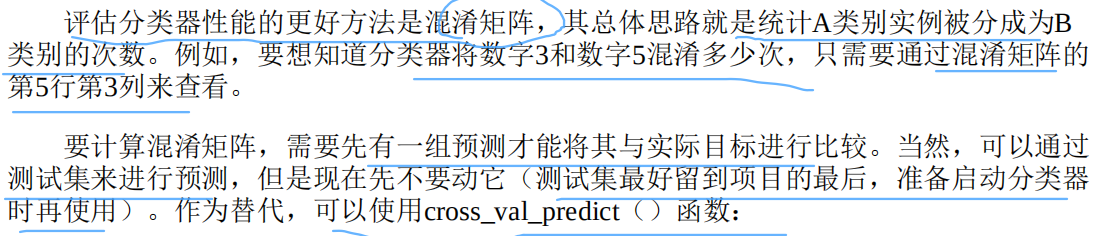

In [49]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [50]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [51]:
# 完美的混淆矩阵，应该只有真正类TP，真负类TN，次对角线全为0
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

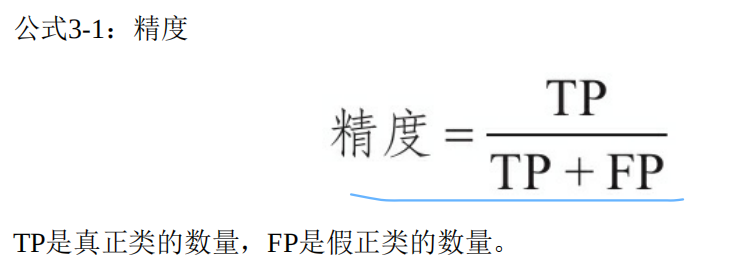
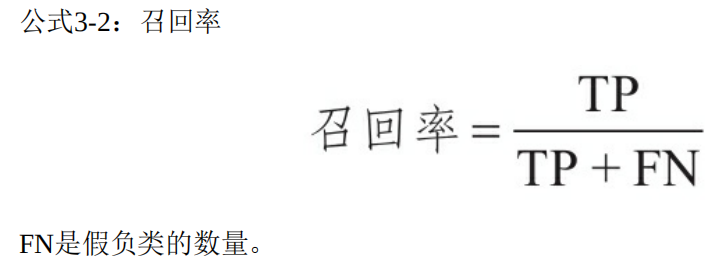

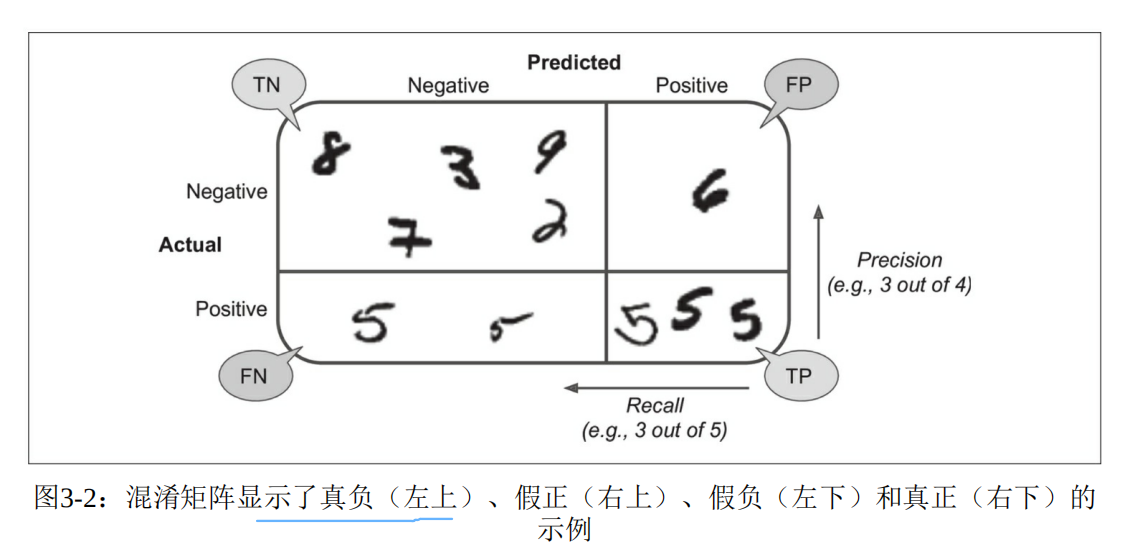

### 精度Precision和召回率Recall

In [52]:
from sklearn.metrics import precision_score,recall_score

precision_score(y_train_5,y_train_pred)

0.8370879772350012

In [53]:
cm = confusion_matrix(y_train_5,y_train_pred)
cm[1,1]/(cm[0,1]+cm[1,1])

0.8370879772350012

In [54]:
recall_score(y_train_5,y_train_pred)

0.6511713705958311

In [56]:
cm[1,1] / (cm[1,1] + cm[1,0])

0.6511713705958311

### F1分数

F1分数是精度和召回率 的谐波平均值，正常的平均值平等对待所有的值，而谐波平均值会给予低 值更高的权重。因此，只有当召回率和精度都很高时，分类器才能得到较高的F1分数。

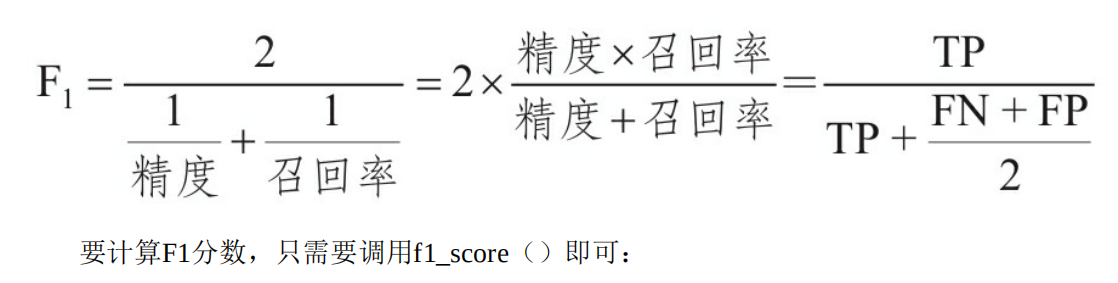

In [57]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7325171197343846

In [59]:
cm[1,1] / (cm[1,1] + (cm[1,0] + cm[0,1])/2)

0.7325171197343847

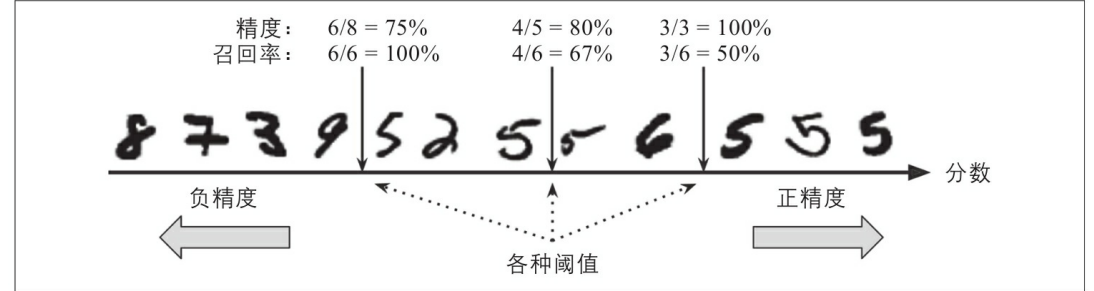


# Sklearn不允许直接设置阈值，但是可以访问它用于预测的决策分数

# 通过调用decision_function(),根据分数来对任意阈值进行预测

In [61]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [63]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [64]:
# 提升阈值
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

### 使用cross_val_predict（）函数获取训练集 中所有实例的分数

In [66]:
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method='decision_function')

### 有了这些分数，可以使用precision_recall_curve（）函数来计算所有可能的阈值的精度和召回率

In [68]:
from sklearn.metrics import precision_recall_curve

precisions,recalls,thresholds = precision_recall_curve(y_train_5,y_scores)

### 使用Matplotlib绘制精度和召回率相对于阈值的函数图

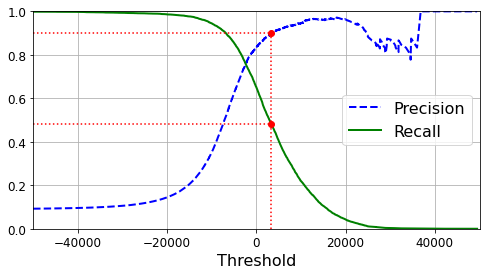

In [69]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

In [70]:
(y_train_pred == (y_scores > 0)).all()

True

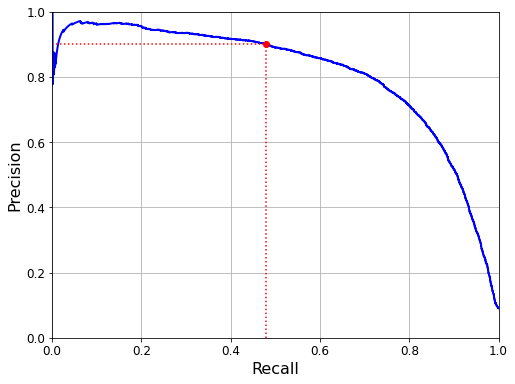

In [72]:
# 仅绘制精确率和召回率区线  
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [73]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439594

In [74]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [75]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### ROC区线

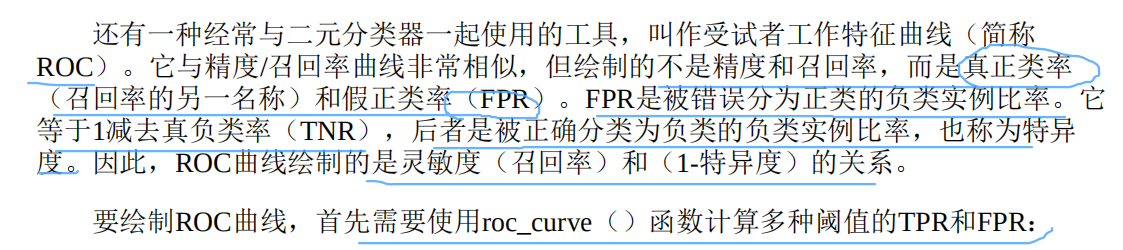

In [76]:
from sklearn.metrics import roc_curve

In [77]:
fpr, tpr, thresholds = roc_curve(y_train_5,y_scores)

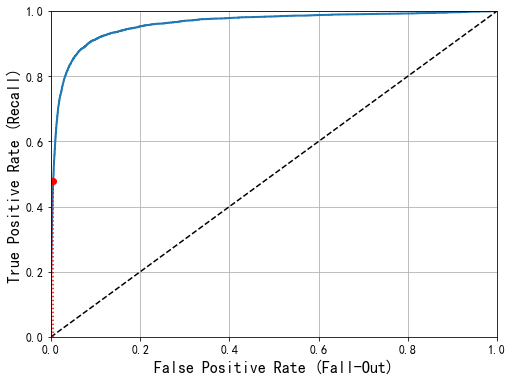

In [84]:
plt.rcParams['font.sans-serif']=['SimHei'] # 用黑体显示中文
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown                        
plt.show()

### AUC 为ROC曲线下的面积

In [83]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

## 当正类非常少见或者你更关注假正类而不是假负类时， 应该选择PR曲线，反之则是ROC曲线

### 训练一个RandomForestClassifier（随机森林）分类器，并比较它和SGDClassifier分类器 的ROC曲线和ROC AUC分数

### RandomForestClassifier类没有decision_function（）方法，相反，它有dict_proba（）方法。
### Scikit-Learn的分类器通常都会有这两种方法中的一种（或 两种都有）。
### dict_proba（）方法会返回一个数组，其中每行代表一个实例，每列代表一个类别，
### 意思是某个给定实例属于某个给定类别的概率（例如，这张图片有70%的可能是 数字5）

In [85]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

### roc_curve（）函数需要标签和分数，但是我们不提供分数，而是提供类概率。我们直 接使用正类的概率作为分数值

In [86]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

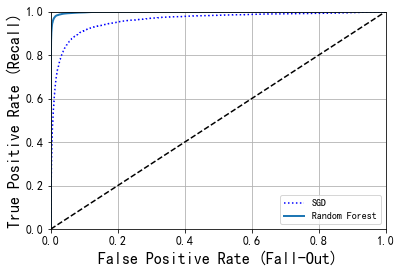

In [87]:
plt.plot(fpr, tpr, "b:", label="SGD") 
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest") 
plt.legend(loc="lower right") 
plt.show()

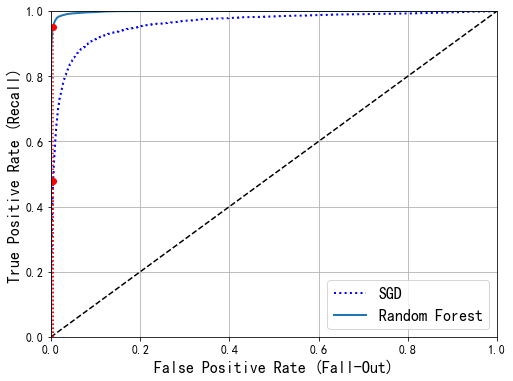

In [89]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [91]:
# 目测随机森林的曲线更好，  查看AUC得分
roc_auc_score(y_train_5,y_scores_forest)

0.9983436731328145

In [92]:
# 查看精确率
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [93]:
# 召回率
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

## 多类分类器 Multiclass Classification

### 二元分类器在两个类中区分，而多类分类器（也称为多项分类器）可以区分两个以上 的类。

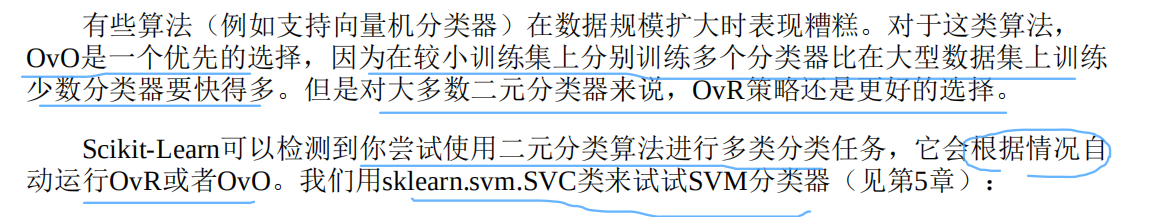

In [94]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

### 调用decision_function（）方法。它会返回10个分数

In [97]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores  #第5个数字最大

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [98]:
np.argmax(some_digit_scores)

5

In [99]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [100]:
svm_clf.classes_[5]

5

### 如果想要强制Scikit-Learn使用一对一或者一对剩余，可以使用OneVsOneClassifier或OneVsRestClassifier类。
### 只需要创建一个实例，然后将分类器传给其 构造函数（它甚至不必是二元分类器）。
### 例如，下面这段代码使用OvR策略，基于SVC创 建了一个多类分类器

In [101]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma='auto',random_state=42))
ovr_clf.fit(X_train[:1000],y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [102]:
len(ovr_clf.estimators_)

10

In [104]:
# 训练SGDClassifier或者RandomForestClassifier同样简单：
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

### 这次Scikit-Learn不必运行OvR或者OvO了，因为SGD分类器直接就可以将实例分为多个类。
### 调用decision_function（）可以获得分类器将每个实例分类为每个类的概率列表：

In [128]:
sgd_clf.decision_function([some_digit])
# some_digit = X[0],表示的是X0的784个特征组合成的像素点
# 这里是将该数字依次判别为0，1，2，...9 之后的得分，这里判别为了3

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

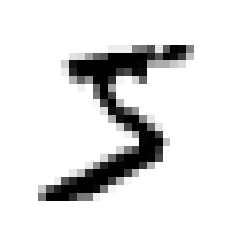

In [127]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image,cmap='binary')
plt.axis('off')
plt.show();

## 3.5 误差分析

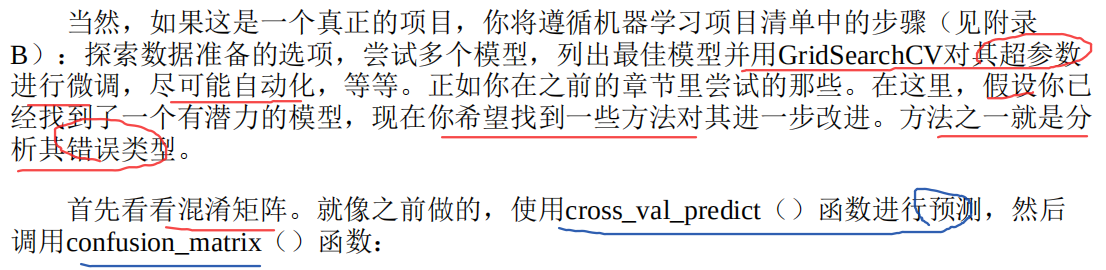

### 这一部分详见 官方书籍代码

## 3.6 多标签分类


In [131]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7) # 7,8,9
y_train_odd = (y_train % 2 == 1) # 奇数
y_multilabel = np.c_[y_train_large, y_train_odd] #将大于等于7的和奇数拼接， 1，3，5，7，8，9

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [132]:
knn_clf.predict([some_digit])
# 结果表示 5不大(小与7), 为奇数

array([[False,  True]])

**Warning**: the following cell may take a very long time (possibly hours depending on your hardware).

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

## 3.7多输出分类 Multioutput Classification

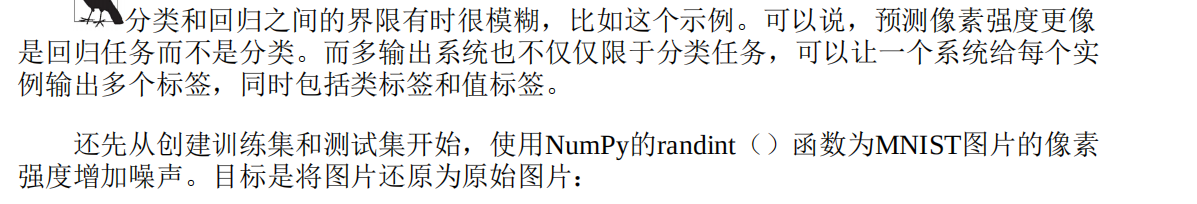

In [135]:
noise = np.random.randint(0,100,(len(X_train),784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100,(len(Xtest),784))
X_test_mod = Xtest + noise
y_train_mod = X_train
y_test_mod = Xtest

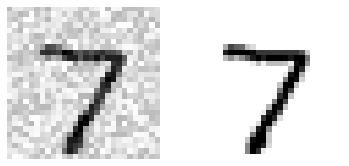

In [137]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

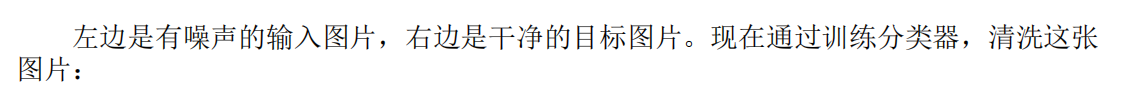

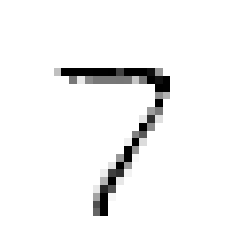

In [138]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

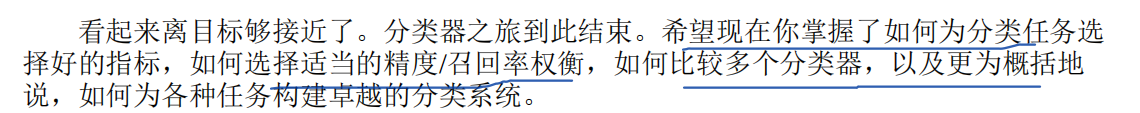